# Install Package

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

## Gathering Data from kaggle

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
!kaggle datasets download -d nikhil7280/student-performance-multiple-linear-regression

Dataset URL: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression
License(s): other
student-performance-multiple-linear-regression.zip: Skipping, found more recently modified local copy (use --force to force download)


### Extract File Zip

In [ ]:
import zipfile

In [ ]:
dataset = zipfile.ZipFile('/content/student-performance-multiple-linear-regression.zip', 'r')

dataset.extractall()

## EDA & Preprocessing Data

In [ ]:
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
# Checking outlier data in dataset

df.describe(include='all')

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,5052,NaN,NaN,NaN
mean,4.992900,69.445700,NaN,6.530600,4.583300,55.224800
std,2.589309,17.343152,NaN,1.695863,2.867348,19.212558
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000,40.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,71.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [ ]:
#Check for missing values
print(df.isnull().sum())

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


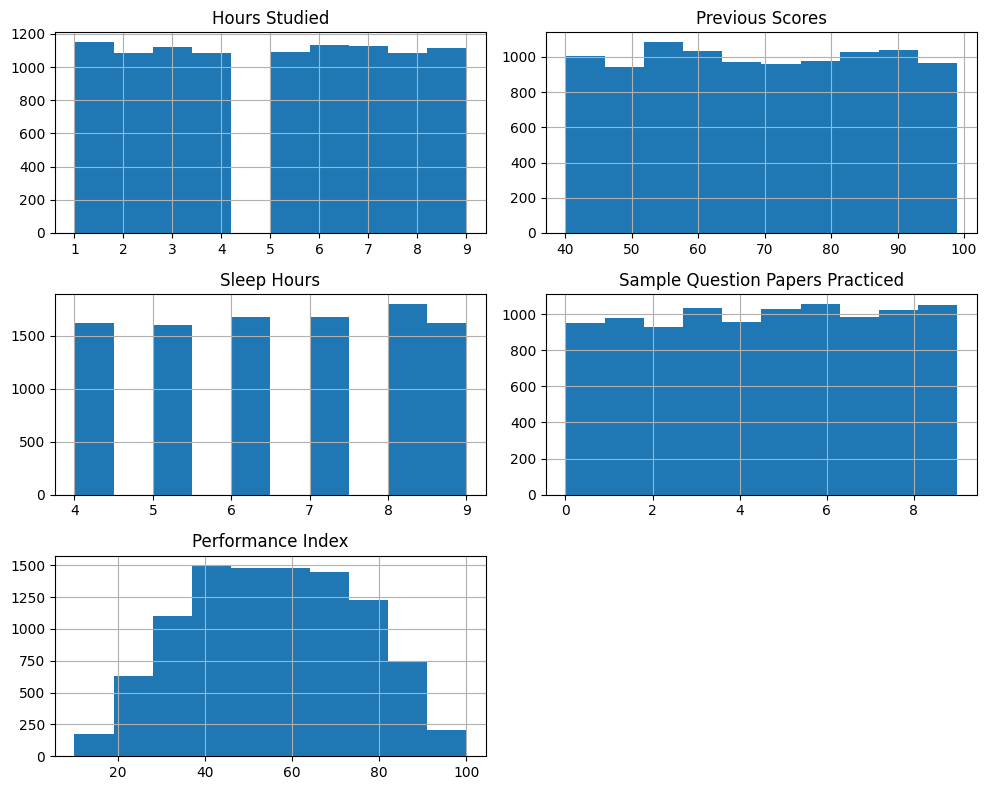

In [ ]:
#To visualize the data
df[['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']].hist(bins=10, figsize=(10, 8))
plt.tight_layout()
plt.show()

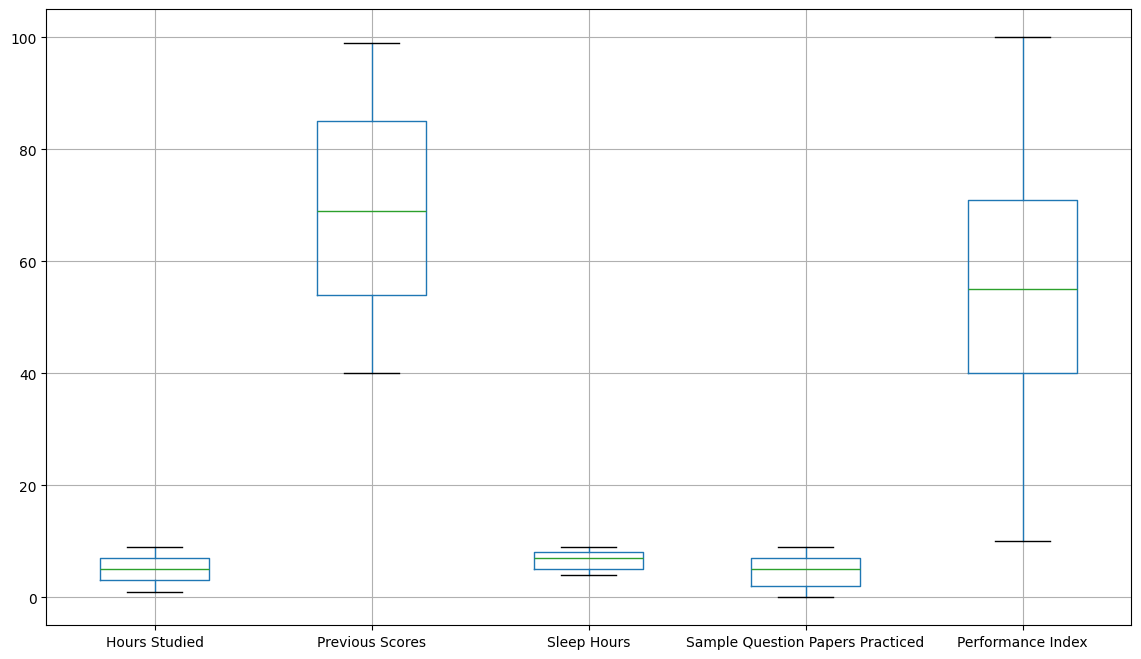

In [ ]:
#To define the outliers
df[['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']].boxplot(figsize=(14,8))
plt.show()

<Axes: >

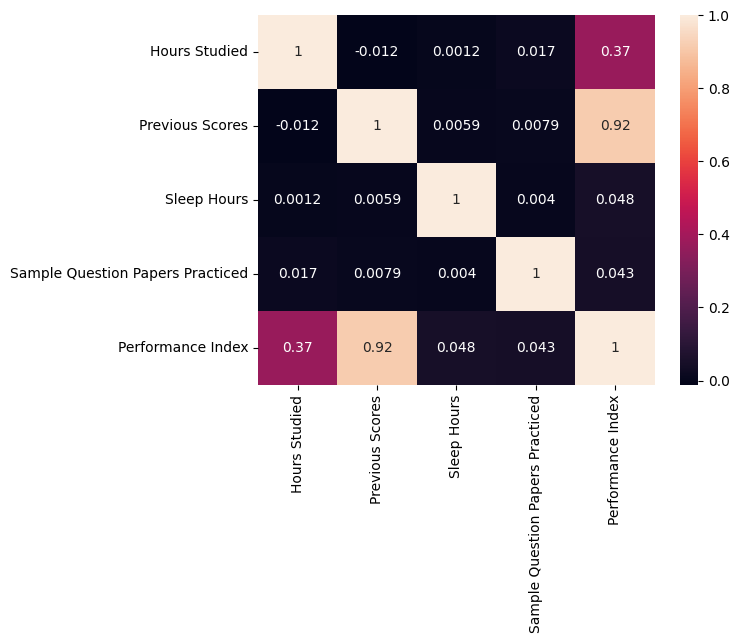

In [ ]:
#Correlation analysis
corr = df.drop(columns=['Extracurricular Activities']).corr()
sns.heatmap(corr, annot=True)
#Looks like Sample questions papers Practiced and Sleep hours does not correlate well with performance index, we will keep them for now.

In [ ]:
df = pd.get_dummies(df, columns=['Extracurricular Activities'])
df.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_No,Extracurricular Activities_Yes
0,7,99,9,1,91.0,False,True
1,4,82,4,2,65.0,True,False
2,8,51,7,2,45.0,False,True
3,5,52,5,2,36.0,False,True
4,7,75,8,5,66.0,True,False


In [ ]:
def f(x):
  if x == False:
    return 0
  elif x == True:
    return 1

column_bool = ['Extracurricular Activities_No', 'Extracurricular Activities_Yes']
for column in column_bool:
  df[column] = df[column].apply(f)

df['Extracurricular'] = df['Extracurricular Activities_Yes'] * 1  # Convert True to 1, False to 0
df = df.drop(['Extracurricular Activities_Yes', 'Extracurricular Activities_No'], axis=1)
df.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular
0,7,99,9,1,91.0,1
1,4,82,4,2,65.0,0
2,8,51,7,2,45.0,1
3,5,52,5,2,36.0,1
4,7,75,8,5,66.0,0


In [ ]:
df.to_csv('Student_Performance_Clean.csv', index=False)

## Processing Data

In [ ]:
# Load Dataset
data = pd.read_csv('/content/Student_Performance_Clean.csv')

In [ ]:
# Define Features and Target
X = data[['Hours Studied', 'Sleep Hours', 'Previous Scores', 'Sample Question Papers Practiced', 'Extracurricular']]
y = data['Performance Index']

In [ ]:
# Normalize Features and Target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000, 1), (2000, 1))

In [ ]:
#Converting all data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Modelling

In [ ]:
#Building model
tf.random.set_seed(42)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

model.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae']
)

## Train Model

In [ ]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs = 100
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0716 - mae: 0.0716
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - mae: 0.0221
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0203 - mae: 0.0203
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0207 - mae: 0.0207
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0208 - mae: 0.0208
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0203 - mae: 0.0203
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0195 - mae: 0.0195
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mae: 0.0200
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0199 - mae: 0.0199
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - mae: 0.0198
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - mae: 0.0197
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - mae: 0.0195
Epoch 13/100


## Evaluate Model

In [ ]:
# Evaluate Model
loss, mae = model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185 - mae: 0.0185


In [ ]:
#Predicting values based on model
y_preds_scaled = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Plot Loss and MAE
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

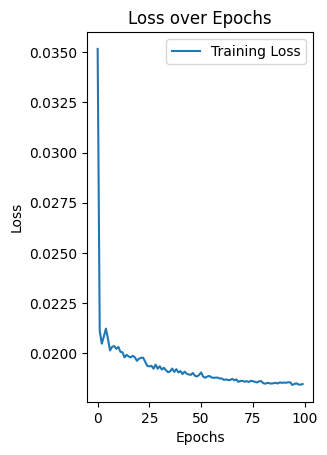

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

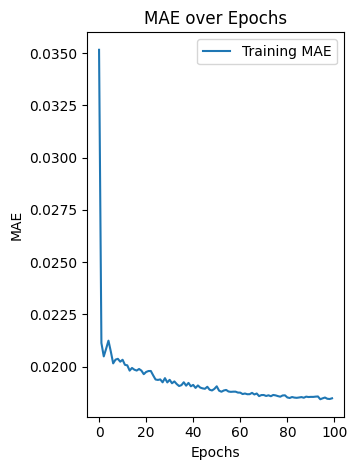

In [ ]:
# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Rescale predictions to original scale
y_preds = scaler_y.inverse_transform(y_preds_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
#Defining function to plot y_test against y_preds
def plot_predictions(y_test_original, y_preds):
  plt.scatter(y_test_original, y_preds)
  plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], color='red', lw=2)  # Diagonal line
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')
  plt.title('Predicted vs Actual')
  plt.show()

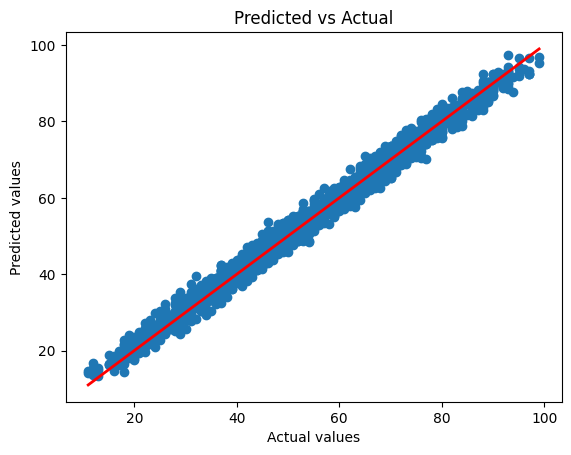

In [ ]:
# Visualize Predictions vs Actual
plot_predictions(y_test_original, y_preds)

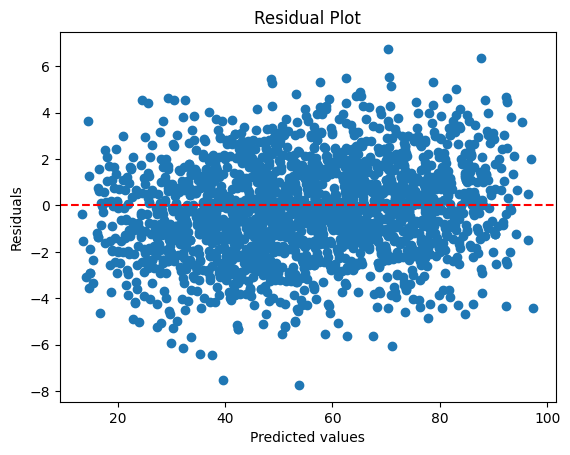

In [ ]:
# Visualize Residuals
residuals = y_test_original.flatten() - y_preds.flatten()
plt.scatter(y_preds.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming y_test_original and y_pred are your actual and predicted values
mae = mean_absolute_error(y_test_original, y_preds)
mape = np.mean(np.abs((y_test_original - y_preds.flatten()) / y_test)) * 100
mse = mean_squared_error(y_test_original, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_preds)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 1.6558188199996948
Mean Absolute Percentage Error: 7423.113250732422
Mean Squared Error: 4.31549072265625
Root Mean Squared Error: 2.077375888824463
R2 Score: 0.9883549213409424


# One Example to Test the Model

In [ ]:
def predict_performance(model, scaler_X, scaler_y, Hours_Studied, Sleep_Hours, Previous_Scores, Sample_Question_Papers_Practiced, Extracurricular_Activities):
  """
  Memprediksi Performance Index berdasarkan input fitur.

  Args:
    model: Model TensorFlow yang sudah dilatih.
    scaler_X: MinMaxScaler untuk fitur.
    scaler_y: MinMaxScaler untuk target.
    Hours_Studied: Jumlah jam belajar (0-24).
    Sleep_Hours: Jumlah jam tidur (0-24).
    Previous_Scores: Skor sebelumnya (0-100).
    Sample_Question_Papers_Practiced: Jumlah lembar soal latihan yang dikerjakan (0-100).
    Extracurricular: Apakah siswa mengikuti kegiatan ekstrakurikuler ('Yes' atau 'No').

  Returns:
    Prediksi Performance Index.
  """

  # Batasan Input
  if not 0 <= Hours_Studied <= 24:
    raise ValueError("Hours Studied harus berada di antara 0 dan 24.")
  if not 0 <= Sleep_Hours <= 24:
    raise ValueError("Sleep Hours harus berada di antara 0 dan 24.")
  if not 0 <= Previous_Scores <= 100:
    raise ValueError("Previous Scores harus berada di antara 0 dan 100.")
  if not 0 <= Sample_Question_Papers_Practiced <= 100:
    raise ValueError("Sample Question Papers Practiced harus berada di antara 0 dan 100.")

  # Batasan total jam belajar dan tidur
  if Hours_Studied + Sleep_Hours > 24:
    raise ValueError("Total Hours Studied dan Sleep Hours tidak boleh lebih dari 24 jam.")


  # Konversi Extracurricular_Activities ke one-hot encoding
  if Extracurricular_Activities == 'Yes':
    Extracurricular = 1
  else:
    Extracurricular = 0

  # Buat input array
  input_data = [[Hours_Studied, Sleep_Hours, Previous_Scores, Sample_Question_Papers_Practiced, Extracurricular]]

  # Scaling input
  input_data_scaled = scaler_X.transform(input_data)

  # Prediksi
  prediction_scaled = model.predict(input_data_scaled)

  # Kembalikan ke skala asli
  prediction = scaler_y.inverse_transform(prediction_scaled)[0][0]

    # Batasan Performance Index
  if prediction > 100:
    prediction = 100

  return prediction

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Contoh penggunaan untuk per hari
Hours_Studied = 10
Sleep_Hours = 10
Previous_Scores = 100
Sample_Question_Papers_Practiced = 10
Extracurricular_Activities = 'Yes'

predicted_performance = predict_performance(model, scaler_X, scaler_y, Hours_Studied, Sleep_Hours, Previous_Scores, Sample_Question_Papers_Practiced, Extracurricular_Activities)

print(f"Prediksi Performance Index: {predicted_performance:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediksi Performance Index: 100.00


# Save Model

In [ ]:
# prompt: buatkan save model

model.save('student_performance__fix_model.h5')